In [3]:
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
import os

In [5]:
!nvidia-smi

Tue Jan  6 12:06:22 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.07             Driver Version: 581.80         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   48C    P0             26W /  175W |       0MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
import requests

for url in [
    "https://media.roboflow.com/notebooks/examples/dog-2.jpeg",
    "https://media.roboflow.com/notebooks/examples/dog-3.jpeg",
]:
    name = url.rsplit("/", 1)[-1]
    with open(name, "wb") as f:
        f.write(requests.get(url, stream=True).content)
    print("saved", name)


saved dog-2.jpeg
saved dog-3.jpeg


rf-detr-medium.pth: 100%|██████████| 386M/386M [00:14<00:00, 27.9MiB/s] 


Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


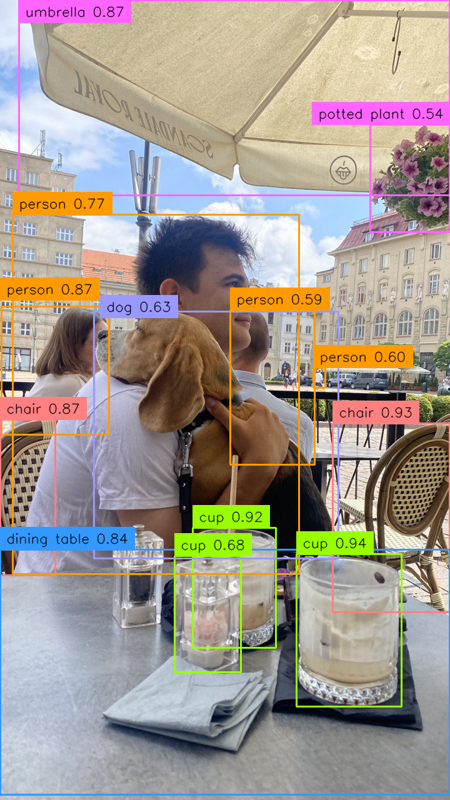

In [8]:
import numpy as np
import supervision as sv

from PIL import Image

from rfdetr import RFDETRMedium
from rfdetr.util.coco_classes import COCO_CLASSES

image = Image.open("dog-2.jpeg")

model = RFDETRMedium(resolution=640)
model.optimize_for_inference()

detections = model.predict(image, threshold=0.5)

color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    smart_position=True
)

labels = [
    f"{COCO_CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = bbox_annotator.annotate(annotated_image, detections)
annotated_image = label_annotator.annotate(annotated_image, detections, labels)
annotated_image.thumbnail((800, 800))
annotated_image

In [4]:
from roboflow import download_dataset

dataset = download_dataset("https://universe.roboflow.com/roboflow-jvuqo/basketball-player-detection-2/13", "coco")

loading Roboflow workspace...
loading Roboflow project...


In [5]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("device count:", torch.cuda.device_count())
    print("device 0:", torch.cuda.get_device_name(0))
    print("capability:", torch.cuda.get_device_capability(0))
    a = torch.randn(2, 2).cuda()
    print("tensor on gpu:", a.device, a)

torch: 2.5.1+cu121
cuda available: True
device count: 1
device 0: NVIDIA GeForce RTX 4090 Laptop GPU
capability: (8, 9)
tensor on gpu: cuda:0 tensor([[ 1.3830, -0.6029],
        [-0.7619,  0.0071]], device='cuda:0')


In [6]:
from rfdetr import RFDETRMedium

model = RFDETRMedium()

model.train(dataset_dir=dataset.location, epochs=30, batch_size=4, grad_accum_steps=4)

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


num_classes mismatch: model has 90 classes, but your dataset has 6 classes
reinitializing your detection head with 6 classes.


Unable to initialize TensorBoard. Logging is turned off for this session.  Run 'pip install tensorboard' to enable logging.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=6, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=30, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-medium.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=4, dim_feedforward=2048, hidden_dim=256, sa_nheads=8, ca_nheads=16,

Epoch: [0]  [ 0/65]  eta: 0:14:05  lr: 0.000100  class_error: 72.84  loss: 12.1538 (12.1538)  loss_ce: 0.8430 (0.8430)  loss_bbox: 0.3935 (0.3935)  loss_giou: 1.0624 (1.0624)  loss_ce_0: 0.7404 (0.7404)  loss_bbox_0: 0.5467 (0.5467)  loss_giou_0: 1.2571 (1.2571)  loss_ce_1: 0.7988 (0.7988)  loss_bbox_1: 0.4485 (0.4485)  loss_giou_1: 1.1479 (1.1479)  loss_ce_2: 0.8315 (0.8315)  loss_bbox_2: 0.4143 (0.4143)  loss_giou_2: 1.0818 (1.0818)  loss_ce_enc: 0.7046 (0.7046)  loss_bbox_enc: 0.5689 (0.5689)  loss_giou_enc: 1.3144 (1.3144)  loss_ce_unscaled: 0.8430 (0.8430)  class_error_unscaled: 72.8438 (72.8438)  loss_bbox_unscaled: 0.0787 (0.0787)  loss_giou_unscaled: 0.5312 (0.5312)  cardinality_error_unscaled: 3866.7500 (3866.7500)  loss_ce_0_unscaled: 0.7404 (0.7404)  loss_bbox_0_unscaled: 0.1093 (0.1093)  loss_giou_0_unscaled: 0.6286 (0.6286)  cardinality_error_0_unscaled: 3445.2500 (3445.2500)  loss_ce_1_unscaled: 0.7988 (0.7988)  loss_bbox_1_unscaled: 0.0897 (0.0897)  loss_giou_1_unscaled:

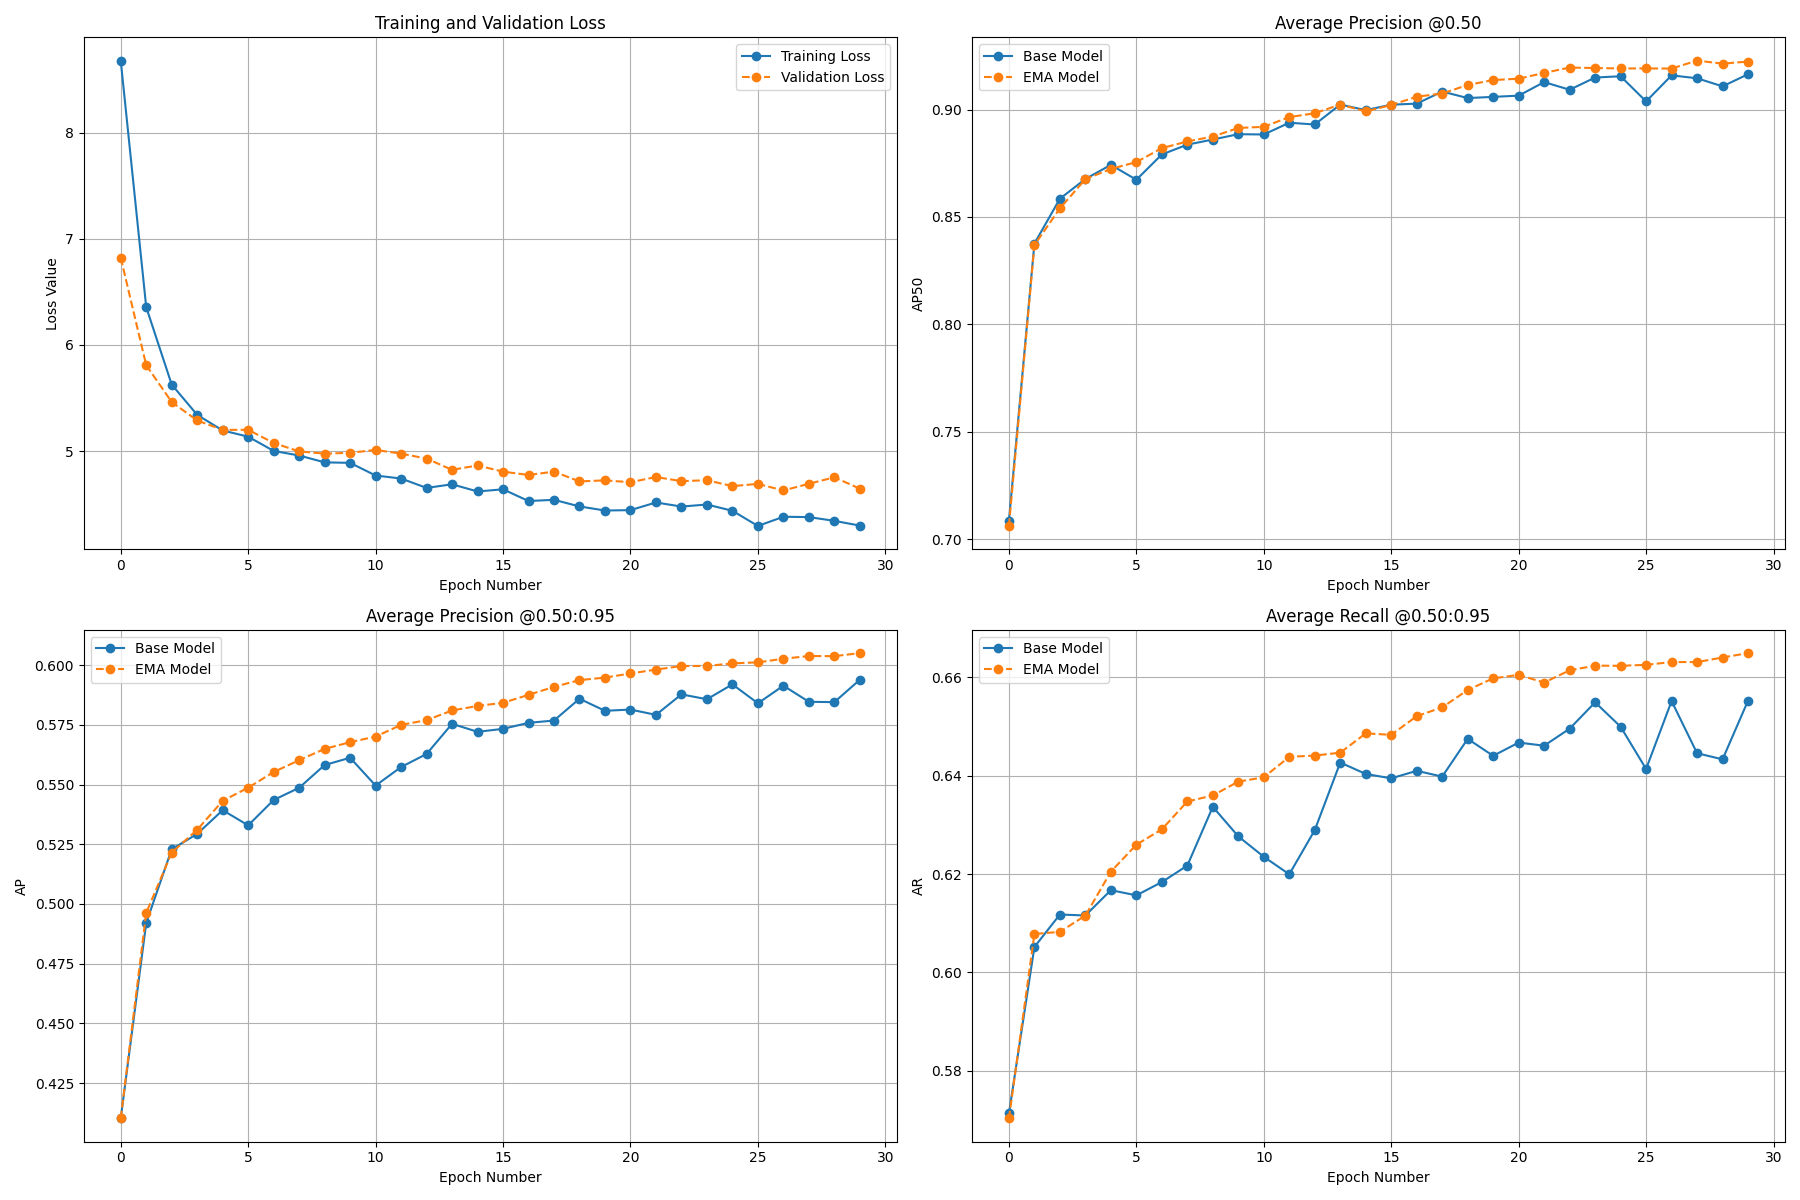

In [8]:
from PIL import Image

Image.open("output/metrics_plot.png")

In [10]:
!dir -la output

 Volume in drive C is OS
 Volume Serial Number is 9685-C89B

 Directory of c:\Users\kevor\Documents\ML_journey\random_code\basketball


 Directory of c:\Users\kevor\Documents\ML_journey\random_code\basketball\output

12/07/2025  10:58 PM    <DIR>          .
12/07/2025  10:05 PM    <DIR>          ..
12/07/2025  10:57 PM       535,030,322 checkpoint.pth
12/07/2025  10:21 PM       535,040,506 checkpoint0009.pth
12/07/2025  10:39 PM       535,040,506 checkpoint0019.pth
12/07/2025  10:57 PM       535,040,506 checkpoint0029.pth
12/07/2025  10:58 PM       401,311,893 checkpoint_best_ema.pth
12/07/2025  10:12 PM       401,320,105 checkpoint_best_regular.pth
12/07/2025  10:58 PM       133,737,414 checkpoint_best_total.pth
12/07/2025  10:06 PM    <DIR>          eval
12/07/2025  10:58 PM           241,728 log.txt
12/07/2025  10:58 PM           170,539 metrics_plot.png
12/07/2025  10:58 PM             1,707 results.json
              10 File(s)  3,076,935,226 bytes
               3 Dir(s)  1,165,5

File Not Found


In [15]:
model.deploy_to_roboflow(
  workspace="kevsstuff",
  project_id="basketball-player-detection-2-izc11",
  version=1,
  api_key=os.environ["ROBOFLOW_API_KEY"]
)

loading Roboflow workspace...
loading Roboflow project...
View the status of your deployment at: https://app.roboflow.com/kevsstuff/basketball-player-detection-2-izc11/1
Share your model with the world at: https://universe.roboflow.com/kevsstuff/basketball-player-detection-2-izc11/model/1


In [16]:
import gc
import torch
import weakref

def cleanup_gpu_memory(obj=None, verbose: bool = False):

    if not torch.cuda.is_available():
        if verbose:
            print("[INFO] CUDA is not available. No GPU cleanup needed.")
        return

    def get_memory_stats():
        allocated = torch.cuda.memory_allocated()
        reserved = torch.cuda.memory_reserved()
        return allocated, reserved

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[Before] Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

    # Ensure we drop all strong references
    if obj is not None:
        ref = weakref.ref(obj)
        del obj
        if ref() is not None and verbose:
            print("[WARNING] Object not fully garbage collected yet.")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[After]  Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

In [17]:
cleanup_gpu_memory(model, verbose=True)

[Before] Allocated: 144.50 MB | Reserved: 5166.00 MB
[WARNING] Object not fully garbage collected yet.
[After]  Allocated: 144.50 MB | Reserved: 294.00 MB


In [18]:
model = RFDETRMedium(pretrain_weights="output/checkpoint_best_total.pth")
model.optimize_for_inference()

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.


num_classes mismatch: pretrain weights has 5 classes, but your model has 90 classes
reinitializing detection head with 5 classes


Loading pretrain weights


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


In [19]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

In [20]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 169/169 [00:07<00:00, 21.33it/s]


In [21]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()
print(map_result)

Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.603
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.935
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.643
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.347
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]                 = 0.779
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]                 = 0.837


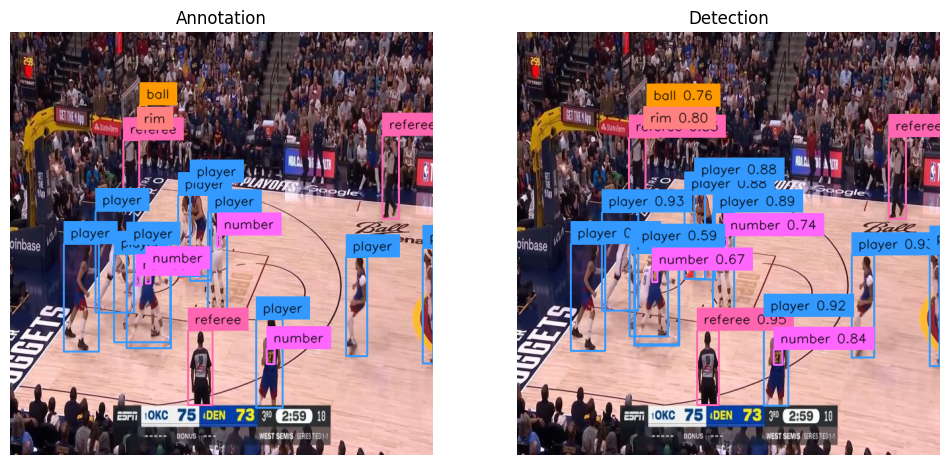

In [22]:
from rfdetr import RFDETRBase
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

bbox_annotator = sv.BoxAnnotator(color=color,thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

In [23]:
from inference import get_model

MODEL_ID = "basketball-player-detection-2-izc11/1"
model_rf = get_model(model_id=MODEL_ID, api_key = os.environ["ROBOFLOW_API_KEY"])

[12/07/25 23:10:26] WARNING  Your inference package version 0.51.7 is out of date! Please upgrade to ]8;id=660600;file://c:\Users\kevor\anaconda3\envs\roboflow\lib\site-packages\inference\core\__init__.py\__init__.py]8;;\:]8;id=241235;file://c:\Users\kevor\anaconda3\envs\roboflow\lib\site-packages\inference\core\__init__.py#41\41]8;;\
                             version 0.62.2 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

ModelDependencyMissing: Your `inference` configuration does not support Qwen2.5-VL model. Use pip install 'inference[transformers]' to install missing requirements.To suppress this warning, set QWEN_2_5_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM2 model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM2_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support CLIP model. Use pip install 'inference[clip]' to install missing requirements.To suppress this warning, set CORE_MODEL_CLIP_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support Gaze Detection model. Use pip install 'inference[gaze]' to install mi

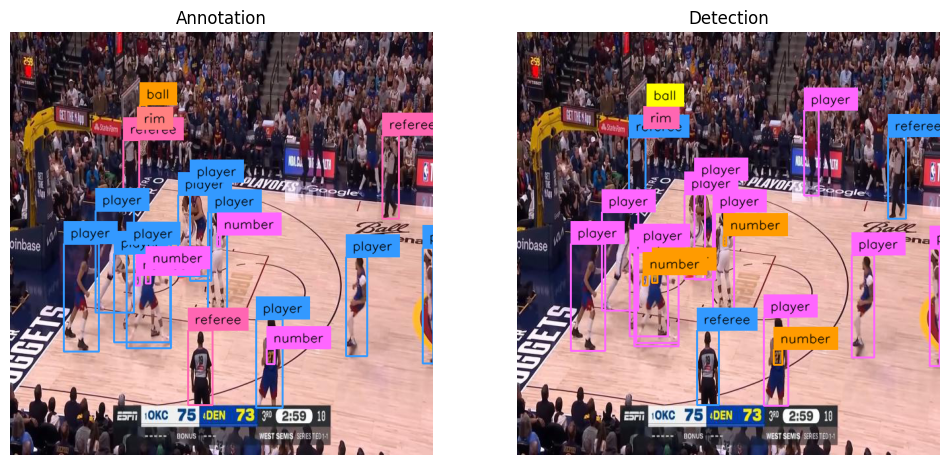

In [24]:
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

result = model_rf.infer(image, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

bbox_annotator = sv.BoxAnnotator(color=color,thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])